<a href="https://colab.research.google.com/github/kihagama/hero/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Application : Prophet RMSE = 14.850 | R² = 0.146


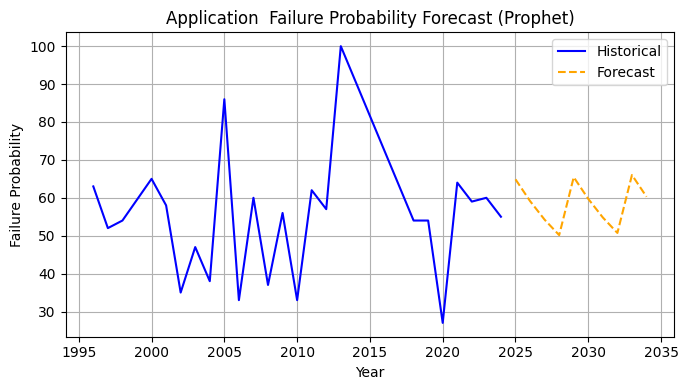

Admision : Prophet RMSE = 17.571 | R² = 0.217


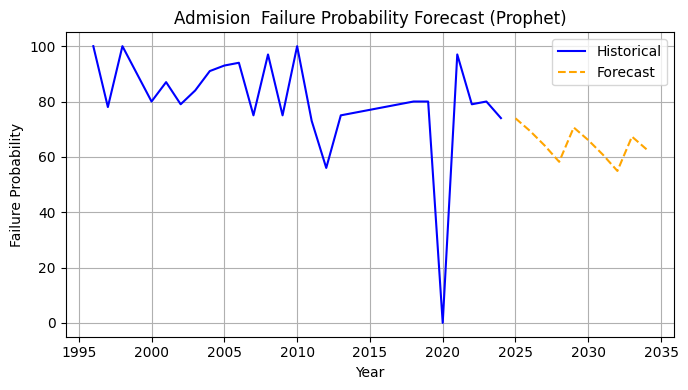

Academic: Prophet RMSE = 4.264 | R² = 0.103


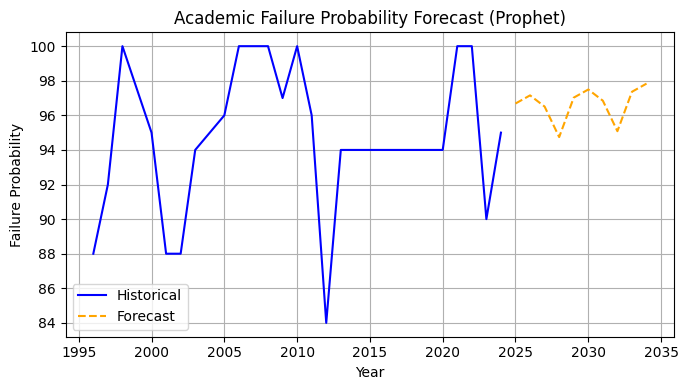

student Portal: Prophet RMSE = 12.240 | R² = 0.023


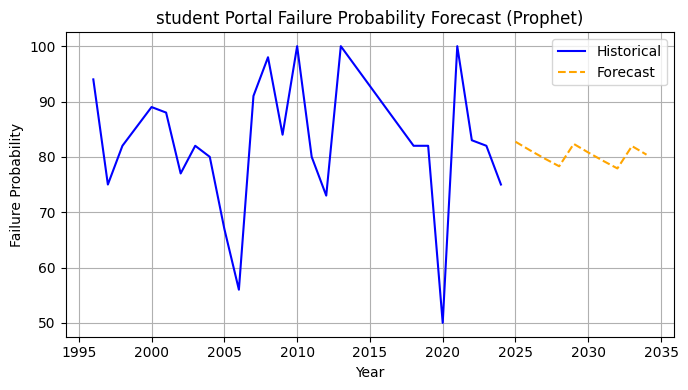


--- Forecasted Failure Probabilities (2025–2034) ---
      Application   Admision   Academic  student Portal
2025        64.872     73.923    96.684          82.733
2026        59.134     69.350    97.155          81.178
2027        54.227     64.112    96.508          79.700
2028        50.157     58.216    94.744          78.298
2029        65.444     70.615    97.024          82.341
2030        59.706     66.042    97.495          80.786
2031        54.799     60.804    96.847          79.308
2032        50.728     54.908    95.083          77.907
2033        66.016     67.307    97.363          81.949
2034        60.278     62.734    97.834          80.394


['prophet_forecast_results.jb']

In [8]:


# SOFTWARE RELIABILITY PREDICTION FOR AIMS GROUP 5 - USING PROPHET
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

import joblib as jb

#Load dataset
data = pd.read_csv("cleaned_data.csv")

#Ensuring 'year' column is integer and set as index
data['year'] = data['year'].astype(int)
data.set_index('year', inplace=True)

#Define forecast range
forecast_years = list(range(2025, 2035))  # Adjust as needed

#Store results
predictions = {}
metrics = {}

#Function to train Prophet model
def fit_prophet(series):
    try:
        df = pd.DataFrame({
            "ds": pd.to_datetime(series.index, format="%Y"),
            "y": series.values
        })
        model = Prophet(yearly_seasonality=True, daily_seasonality=False)
        model.fit(df)

        # Forecast future years
        future = pd.DataFrame({"ds": pd.to_datetime(forecast_years, format="%Y")})
        forecast = model.predict(future)

        # Evaluate model on historical data
        fitted_vals = model.predict(df)["yhat"].values
        overlap = min(len(fitted_vals), len(series))
        y_true = series[-overlap:]
        y_pred = fitted_vals[-overlap:]

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        return forecast["yhat"].values, rmse, r2
    except Exception as e:
        print(f"Prophet failed for series '{series.name}': {e}")
        return np.array([np.nan]*len(forecast_years)), np.nan, np.nan

#Loop through each module ---
for module in data.columns:
    series = data[module].dropna()

    # Skip if too short
    if len(series) < 5:
        print(f"Skipping {module}: not enough data points.")
        continue

    # Fit Prophet model
    forecast, rmse, r2 = fit_prophet(series)
    predictions[module] = forecast
    metrics[module] = {"RMSE": rmse, "R2": r2}

    #Print metrics
    print(f"{module}: Prophet RMSE = {rmse:.3f} | R² = {r2:.3f}")

    #Ploting actual vs forecast
    plt.figure(figsize=(7,4))
    plt.plot(series.index, series, color='blue', label="Historical")
    plt.plot(forecast_years, forecast, color='orange', linestyle='--', label="Forecast")
    plt.title(f"{module} Failure Probability Forecast (Prophet)")
    plt.xlabel("Year")
    plt.ylabel("Failure Probability")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Converting predictions into DataFrame
pred_df = pd.DataFrame(predictions, index=forecast_years)

print("\n--- Forecasted Failure Probabilities (2025–2034) ---")
print(pred_df.round(3))

# Saving Forecasts to CSV and dumping the model
pred_df.to_csv("prophet_forecast_results.csv", index_label='Year')
jb.dump(pred_df, "prophet_forecast_results.jb")
